SCIP status: optimal
Total generation cost: 53711.25 €
presolving:
(round 1, fast)       38 del vars, 1 del conss, 0 add conss, 2 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, fast)       38 del vars, 1 del conss, 0 add conss, 15 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
(round 3, exhaustive) 49 del vars, 1 del conss, 0 add conss, 15 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 4, fast)       49 del vars, 1 del conss, 0 add conss, 15 chg bounds, 5 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (5 rounds: 5 fast, 2 medium, 2 exhaustive):
 49 deleted vars, 1 deleted constraints, 0 added constraints, 15 tightened bounds, 0 added holes, 5 changed sides, 0 cha

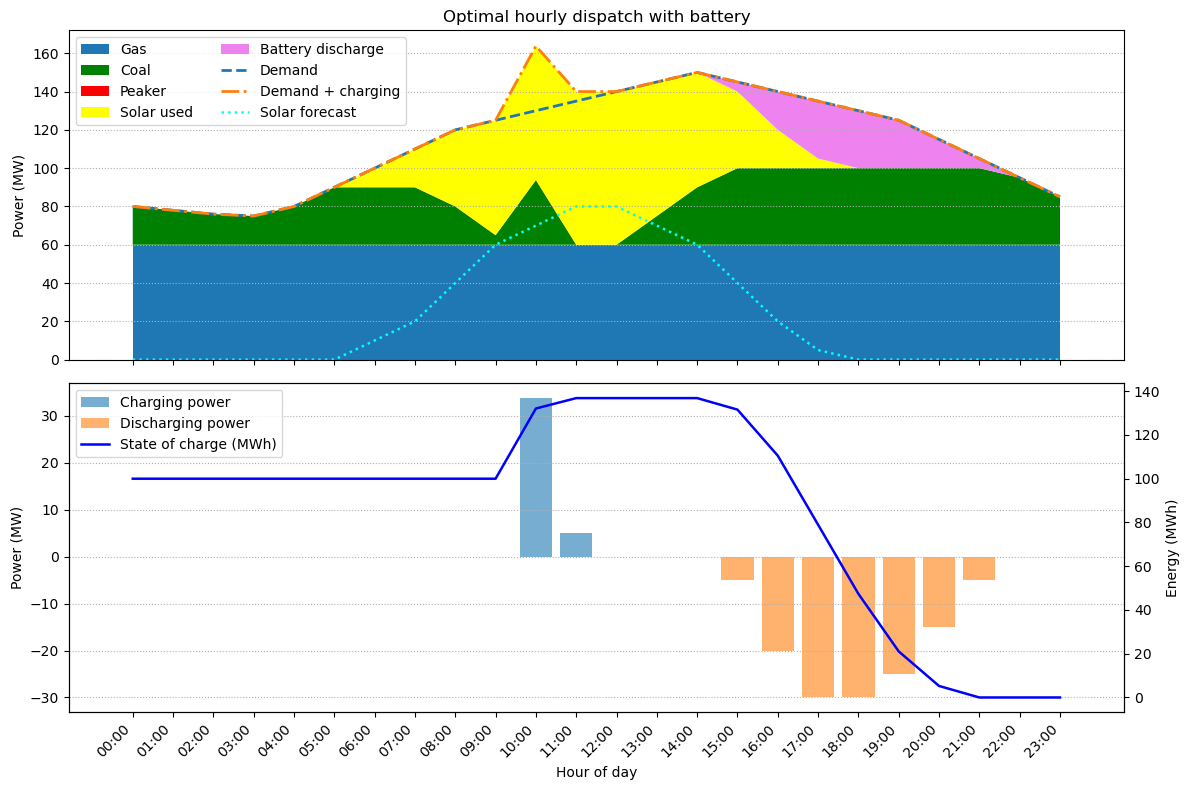

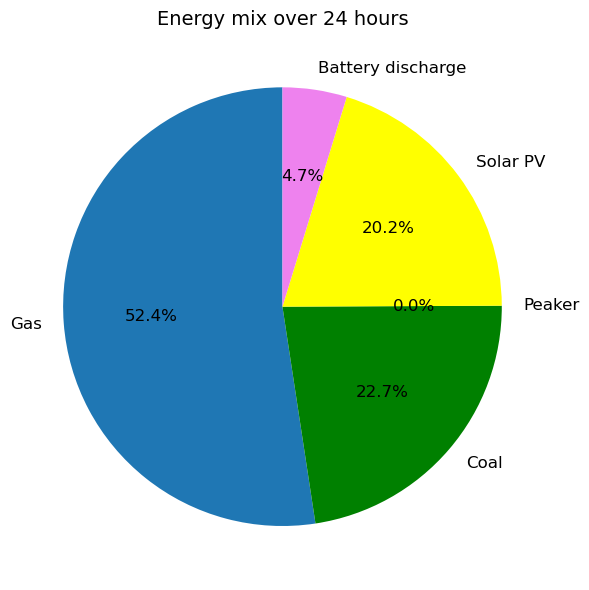

In [1]:
from pyscipopt import Model, quicksum
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# Data
# ==========================

techs = ["Gas", "Coal", "Peaker"]

cost = {    # €/MWh
    "Gas": 20,
    "Coal": 40,
    "Peaker": 120,
}

pmax = {    # MW
    "Gas": 60,
    "Coal": 40,
    "Peaker": 100,
}

# Time index: 24 hours (hourly)
T = range(24)
hours_labels = [f"{h:02d}:00" for h in T]

# Hourly demand (MW)
D = {
    0:  80,  1:  78,  2:  76,  3:  75,
    4:  80,  5:  90,  6: 100,  7: 110,
    8: 120,  9: 125, 10: 130, 11: 135,
    12: 140, 13: 145, 14: 150, 15: 145,
    16: 140, 17: 135, 18: 130, 19: 125,
    20: 115, 21: 105, 22:  95, 23:  85,
}

# Hourly solar PV forecast (MW)
S = {
    0:   0,  1:  0,  2:  0,  3:  0,
    4:   0,  5:  0,  6: 10,  7: 20,
    8:  40,  9: 60, 10: 70, 11: 80,
    12: 80, 13: 70, 14: 60, 15: 40,
    16: 20, 17:  5, 18:  0, 19:  0,
    20:  0, 21:  0, 22:  0, 23:  0,
}

Delta = 1.0  # h

# Battery parameters
x_max   = 200.0   # MWh, energy capacity
P_ch_max  = 50.0  # MW, max charging power
P_dis_max = 50.0  # MW, max discharging power
eta_ch  = 0.95    # charging efficiency
eta_dis = 0.95    # discharging efficiency
x_init  = 100.0   # initial energy (MWh)

# ==========================
# Model
# ==========================

m = Model("multi_period_dispatch_battery")

# Dispatchable generation
u = {(i, t): m.addVar(lb=0.0, ub=pmax[i], name=f"u_{i}_{t}")
     for i in techs for t in T}

# Solar actually used
upv = {t: m.addVar(lb=0.0, ub=S[t], name=f"upv_{t}") for t in T}

# Battery power (charging/discharging) and energy (state of charge)
u_ch  = {t: m.addVar(lb=0.0, ub=P_ch_max,  name=f"u_ch_{t}")  for t in T}
u_dis = {t: m.addVar(lb=0.0, ub=P_dis_max, name=f"u_dis_{t}") for t in T}
x     = {t: m.addVar(lb=0.0, ub=x_max,     name=f"E_{t}")     for t in T}

# Power balance: generation + PV + battery discharge = demand + battery charging
for t in T:
    m.addCons(
        quicksum(u[i, t] for i in techs) + upv[t] + u_dis[t]
        == D[t] + u_ch[t],
        name=f"balance_{t}",
    )

# Battery dynamics
for t in T:
    if t == 0:
        m.addCons(
            x[t] == x_init 
                   + (eta_ch * u_ch[t] - (1.0 / eta_dis) * u_dis[t]) * Delta,
            name=f"soc_{t}",
        )
    else:
        m.addCons(
            x[t] == x[t-1]
                   + (eta_ch * u_ch[t] - (1.0 / eta_dis) * u_dis[t]) * Delta,
            name=f"soc_{t}",
        )

# Objective: minimize generation cost (battery assumed costless)
m.setObjective(
    quicksum(cost[i] * u[i, t] * Delta for i in techs for t in T),
    sense="minimize",
)

m.optimize()

print("SCIP status:", m.getStatus())
print(f"Total generation cost: {m.getObjVal():.2f} €")

# ==========================
# Extract solution
# ==========================

gen = {i: [] for i in techs}
pv_used = []
batt_ch = []
batt_dis = []
soc = []

for t in T:
    for i in techs:
        gen[i].append(m.getVal(u[i, t]))
    pv_used.append(m.getVal(upv[t]))
    batt_ch.append(m.getVal(u_ch[t]))
    batt_dis.append(m.getVal(u_dis[t]))
    soc.append(m.getVal(x[t]))

gen_arrays = {i: np.array(gen[i]) for i in techs}
pv_used = np.array(pv_used)
batt_ch = np.array(batt_ch)
batt_dis = np.array(batt_dis)
soc = np.array(soc)
demand = np.array([D[t] for t in T])
solar_forecast = np.array([S[t] for t in T])

# "Demand + Charging" curve
demand_plus_ch = demand + batt_ch



# ==========================
# Visualization
# ==========================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ----- (1) Generation stackplot + curves -----
ax1.stackplot(
    T,
    gen_arrays["Gas"],
    gen_arrays["Coal"],
    gen_arrays["Peaker"],
    pv_used,
    batt_dis,
    labels=["Gas", "Coal", "Peaker", "Solar used", "Battery discharge"],
    colors = ["tab:blue", "green", "red", "yellow", "violet"]
    # step="mid",
)

# Demand
ax1.plot(T, demand, linestyle="--", linewidth=2, label="Demand")

# Demand + charging (grid has to supply this)
ax1.plot(
    T, demand_plus_ch,
    linestyle="-.", linewidth=2,
    label="Demand + charging"
)

# Solar forecast (availability)
ax1.plot(
    T, solar_forecast,
    linestyle=":", linewidth=1.8, color="cyan",
    label="Solar forecast"
)

ax1.set_ylabel("Power (MW)")
ax1.set_title("Optimal hourly dispatch with battery")
ax1.set_xticks(T)
ax1.set_xticklabels(hours_labels, rotation=45, ha="right")
ax1.grid(True, axis="y", linestyle=":")
ax1.legend(loc="upper left", ncol=2)

# ----- (2) Battery behavior -----
# Bars: charging up, discharging down
ax2.bar(T, batt_ch, width=0.8, label="Charging power", alpha=0.6)
ax2.bar(T, -batt_dis, width=0.8, label="Discharging power", alpha=0.6)

ax2.set_ylabel("Power (MW)")
ax2.grid(True, axis="y", linestyle=":")

# Second y-axis: state of charge
ax2b = ax2.twinx()
ax2b.plot(
    T, soc,
    # marker="o", 
    linewidth=1.8,
    label="State of charge (MWh)",
    color="blue"
)
ax2b.set_ylabel("Energy (MWh)")

# Build a combined legend for ax2 + ax2b
handles1, labels1 = ax2.get_legend_handles_labels()
handles2, labels2 = ax2b.get_legend_handles_labels()
ax2b.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

ax2.set_xlabel("Hour of day")
ax2.set_xticks(T)
ax2.set_xticklabels(hours_labels, rotation=45, ha="right")

plt.tight_layout()
plt.savefig("dispatch_with_battery.png")
plt.show()

# ==========================
# Energy mix pie chart
# ==========================

# Total energy (MWh) produced over the day
energy_gas    = gen_arrays["Gas"].sum()    * Delta
energy_coal   = gen_arrays["Coal"].sum()   * Delta
energy_peaker = gen_arrays["Peaker"].sum() * Delta
energy_solar  = pv_used.sum()              * Delta
energy_batt   = batt_dis.sum()             * Delta   # battery discharge counts as supply

labels = [
    "Gas", 
    "Coal", 
    "Peaker", 
    "Solar PV", 
    "Battery discharge"
]

sizes = [
    energy_gas,
    energy_coal,
    energy_peaker,
    energy_solar,
    energy_batt
]

# Colors matched exactly with stackplot order:
pie_colors = ["tab:blue", "green", "red", "yellow", "violet"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    labels=labels,
    colors=pie_colors,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 12}
)

ax.set_title("Energy mix over 24 hours", fontsize=14)
ax.axis("equal")  # keep it circular

plt.tight_layout()
plt.savefig("dispatch_with_battery_energy_mix.png")
plt.show()